<a href="https://colab.research.google.com/github/forsythe-KE/AI-projects/blob/main/english_kiswahili_traslation_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BEFORE RUNNING THE NOTEBOOK, SWITCH YOUR RUNTIME TO GPU

# Fine-tuning a model on a translation task

In this notebook, we will see how to fine-tune one of the hugging-face Transformers model for an **English to Swahili** translation task.The model we will be fine tuning is Helsinki-NLP/opus-mt-en-sw which was trained by University of Helsinski in Finland<br>
Below is the example translation text using pre-trained model
Reference : https://huggingface.co/Helsinki-NLP/opus-mt-en-sw

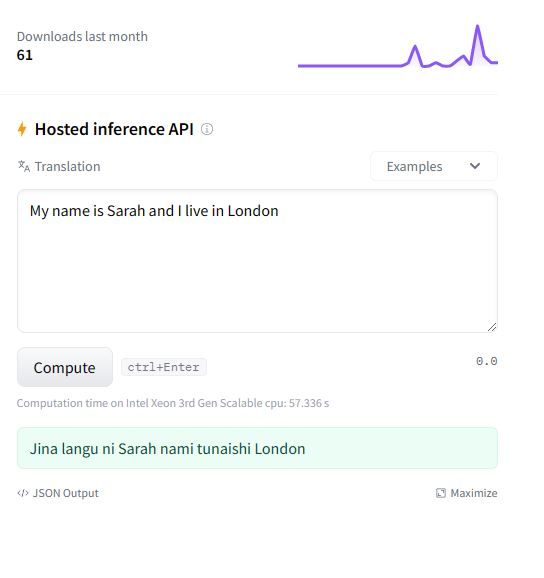

# Install required packages

---



In [ ]:
!pip install -q sacremoses #tokenization and normalization tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install -q sacrebleu #evualuation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 1.3 MB/s eta 0:00:00


In [ ]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00


In [ ]:
!pip install -q  sentencepiece transformers[sentencepiece]  #tokenizer and detokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.5 MB/s eta 0:00:00


Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version

In [ ]:
import transformers
print(transformers.__version__)

4.35.2


In [ ]:
import pandas as pd
import string
import warnings
warnings.filterwarnings("ignore")


# Import the dataset

In [ ]:
#mount drive to google drive
from google.colab import drive

#drive.mount("/content/gdrive")

In [ ]:

df = pd.read_excel('/content/combined.xlsx' ,index_col=False)

In [ ]:
#visualize the top 10 datasets
df.head()

,English sentence,Swahii Translation
0,The government has constructed better health c...,Serikali imejenga vituo bora vya afya vijijini.
1,His death was so sudden.,Kifo chake kilikuwa ghafla.
2,Our company celebrated twenty years of existin...,Kampuni yetu ilisherehekea miaka ishirini ya ...
3,Many people have lost their lives due to sexua...,Watu wengi wamepoteza maisha yao kwa sababu y...
4,Civil servants receive their pension fund upon...,Wafanyikazi wa umma wanapokea fedha zao za pe...


# Data Cleaning


In [ ]:
# converting every letter to lower case
df['English sentence'] = df['English sentence'].apply(lambda x: str(x).lower())
df['Swahii Translation'] = df['Swahii Translation'].apply(lambda x: str(x).lower())

In [ ]:
# removing digits from the sentences
digit = str.maketrans('','',string.digits)
df['English sentence'] = df['English sentence'].apply(lambda x: x.translate(digit))
df['Swahii Translation'] = df['Swahii Translation'].apply(lambda x: x.translate(digit))

In [ ]:
#cleaned datset
df.head()

,English sentence,Swahii Translation
0,the government has constructed better health c...,serikali imejenga vituo bora vya afya vijijini.
1,his death was so sudden.,kifo chake kilikuwa ghafla.
2,our company celebrated twenty years of existin...,kampuni yetu ilisherehekea miaka ishirini ya ...
3,many people have lost their lives due to sexua...,watu wengi wamepoteza maisha yao kwa sababu y...
4,civil servants receive their pension fund upon...,wafanyikazi wa umma wanapokea fedha zao za pe...


In [ ]:
df = df.set_index(df.index, drop=True)

In [ ]:
#convert it back to csv
df = df.reset_index(drop=True)
df = df.to_csv("combined_processed", index=False)

# Loading the dataset

We will use the datasets library to load the already pre processed data from our local storage.

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("csv", data_files="/content/combined_processed")

Generating train split: 0 examples [00:00, ? examples/s]

The dataset object itself is datasetdict, which contains only one split.We have 8492 pairs of sentences.

In [ ]:
# a view on the dataset object
dataset

DatasetDict({
    train: Dataset({
        features: ['English sentence', 'Swahii Translation'],
        num_rows: 999
    })
})

#Split dataset for training and modelling

We have 8492 pairs of sentences, but in one single split, so we will need to create our own validation set

In [ ]:
split_datasets = dataset["train"].train_test_split(train_size=0.8, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['English sentence', 'Swahii Translation'],
        num_rows: 799
    })
    test: Dataset({
        features: ['English sentence', 'Swahii Translation'],
        num_rows: 200
    })
})

In [ ]:
# a look on the dataset
split_datasets["train"][10]["English sentence"], split_datasets["train"][10]["Swahii Translation"]

('a detailed news report will be shared with you.',
 'ripoti ya habari ya kina itashirikiwa na wewe.')

# Load pretrained model

In [ ]:
from transformers import pipeline
# swahili pretraiined model from hugging face
model_checkpoint = "Helsinki-NLP/opus-mt-en-sw"
pretrained_translator = pipeline("translation", model=model_checkpoint)

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/300M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/821k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

In [ ]:
# test pretrained model
pretrained_translator("It is about to rain")

[{'translation_text': 'Mvua iko karibu'}]

# Pre processing with Tokenizers

Before we can feed those texts to our model, we need to preprocess them. This is done by a Transformers Tokenizer which will (as the name indicates) tokenize the inputs and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

we get a tokenizer that corresponds to the model architecture we want to use, we download the vocabulary used when pretraining this specific checkpoint.



In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-sw"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

You can directly call this tokenizer on one sentence or a pair of sentences:

In [ ]:
#encoder
en_sentence = split_datasets["train"][1]["English sentence"]
sw_sentence = split_datasets["train"][1]["Swahii Translation"]

inputs = tokenizer(en_sentence, text_target=sw_sentence)
inputs

{'input_ids': [4, 5628, 480, 8, 55, 56557, 21, 2865, 32, 3265, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [267, 7, 2362, 7, 295, 10777, 678, 7604, 6, 2969, 3, 0]}

The output contains the input IDs associated with the English sentence, while the IDs associated with Swahili  are stored in the labels field.

In [ ]:
#decoder
print(tokenizer.convert_ids_to_tokens(inputs["labels"]))
#decoder
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))

['▁sehemu', '▁ya', '▁kaskazini', '▁ya', '▁u', 'ganda', '▁ime', 'barikiwa', '▁na', '▁dhahabu', '.', '</s>']
['▁the', '▁northern', '▁part', '▁of', '▁', 'uganda', '▁is', '▁blessed', '▁with', '▁gold', '.', '</s>']


We can then write the function that will preprocess our samples. We just feed them to the tokenizer with the argument truncation=True. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.
Note that we set the same maximum length for our inputs and outputs. Since the texts we’re dealing with seem pretty short, we use 128.

In [ ]:
max_length = 128

def preprocess_function(examples):
    inputs = examples['English sentence']
    targets = examples['Swahii Translation']
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
preprocess_function(split_datasets['train'][:2])

{'input_ids': [[69, 4039, 44, 5446, 46, 8844, 3, 0], [4, 5628, 480, 8, 55, 56557, 21, 2865, 32, 3265, 3, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[4124, 383, 1123, 1934, 2929, 843, 75, 3, 0], [267, 7, 2362, 7, 295, 10777, 678, 7604, 6, 2969, 3, 0]]}

To apply this function on all the pairs of sentences in our dataset, we just use the map method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training and validation data will be preprocessed in one single command

In [ ]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True
)

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the AutoModelForSeq2SeqLM class. Like with the tokenizer, the from_pretrained method will download and cache the model for us.

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM,  Seq2SeqTrainingArguments,Seq2SeqTrainer

model = TFAutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-sw", from_pt=True)

All PyTorch model weights were used when initializing TFMarianMTModel.

All the weights of TFMarianMTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


### Data collation

We can now use this data_collator to convert each of our datasets to a tf.data.Dataset, ready for training:

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [ ]:
tf_train_dataset = model.prepare_tf_dataset(
    tokenized_datasets["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)
tf_eval_dataset = model.prepare_tf_dataset(
    tokenized_datasets["test"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

# Setting up Sacrebeu for evaluation

The BLEU score evaluates how close the translations are to their labels. It does not measure the intelligibility or grammatical correctness of the model’s generated outputs, but uses statistical rules to ensure that all the words in the generated outputs also appear in the targets.One weakness with BLEU is that it expects the text to already be tokenized, which makes it difficult to compare scores between models that use different tokenizers. So instead, the most commonly used metric for benchmarking translation models today is SacreBLEU, which addresses this weakness  by standardizing the tokenization step.
The score can go from 0 to 100, and higher is better.

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu")

In [ ]:
# testing  sacrabeu on correct prediction
predictions = [
    "Tutaunda ukuta mpya kuzunguka shule yote."
]
references = [
    [
        "Tutatengeneza ukuta mpya kuzunguka shule."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 43.47208719449914,
 'counts': [5, 3, 2, 1],
 'totals': [7, 6, 5, 4],
 'precisions': [71.42857142857143, 50.0, 40.0, 25.0],
 'bp': 1.0,
 'sys_len': 7,
 'ref_len': 6}

In [ ]:
# testing  on incorrrect  translation
predictions = [
    "Today is a very beatiful day "
]
references = [
    [
        "Python is a language mostly used for machine learning"
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 9.846052248031867,
 'counts': [2, 1, 0, 0],
 'totals': [6, 5, 4, 3],
 'precisions': [33.333333333333336, 20.0, 12.5, 8.333333333333334],
 'bp': 0.6065306597126334,
 'sys_len': 6,
 'ref_len': 9}

### Function to loop through all translation and give evaluation

 Let’s define a function that takes our model and a dataset and computes metrics on it. We’re also going to use a trick that dramatically increases performance - compiling our generation code with XLA, TensorFlow’s accelerated linear algebra compiler. XLA applies various optimizations to the model’s computation graph, and results in significant improvements to speed and memory usage.<br>
we’ll apply the @tf.function(jit_compile=True) decorator to our generation function, which marks the whole function for compilation with XLA.

In [ ]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

generation_data_collator = DataCollatorForSeq2Seq(
    tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=128
)

tf_generate_dataset = model.prepare_tf_dataset(
    tokenized_datasets["test"],
    collate_fn=generation_data_collator,
    shuffle=False,
    batch_size=8,
)


@tf.function(jit_compile=True)
def generate_with_xla(batch):
    return model.generate(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        max_new_tokens=128,
    )
#function ti evaluate the average BLEU SCORE
def compute_metrics():
    all_preds = []
    all_labels = []

    for batch, labels in tqdm(tf_generate_dataset):
        predictions = generate_with_xla(batch)
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = labels.numpy()
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds = [pred.strip() for pred in decoded_preds]
        decoded_labels = [[label.strip()] for label in decoded_labels]
        all_preds.extend(decoded_preds)
        all_labels.extend(decoded_labels)

    result = metric.compute(predictions=all_preds, references=all_labels)
    return {"bleu": result["score"]}

### Score of pretrained model before fine tuning

Before we fine tuning, let’s see what kind of results we get from the  pretrained model without any training

In [ ]:
#print(compute_metrics())
# {'bleu': 32.210752426688764}



# Fine tuning the pretrained model

We can now finetune our model by just calling the compile method

In [ ]:
from transformers import create_optimizer
from transformers.keras_callbacks import PushToHubCallback
import tensorflow as tf

num_epochs = 2
num_train_steps = len(tf_train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,

)
model.compile(optimizer=optimizer)


### Save the model to huggingface

The first step is to log in to Hugging Face, so you’re able to upload your results to the Model Hub. There’s a convenience function to help you with this in a notebook.<br>
This will display a widget where you can enter your Hugging Face login credentials, paste the token from your Hugging Face account.
https://huggingface.co/settings/tokens <br>

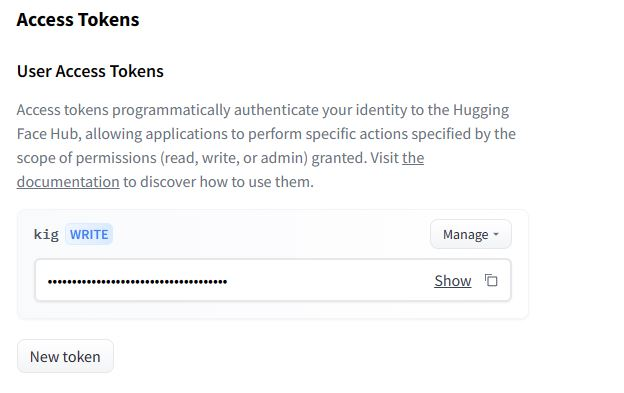

In [ ]:
# login to hugging face
from huggingface_hub import notebook_login
#notebook_login()

Define a PushToHubCallback to upload our model to the Hub during training. Indicate the name of your model in the output dir

In [ ]:
from transformers.keras_callbacks import PushToHubCallback

#callback = PushToHubCallback(
    #output_dir="eng-sw_translation4", tokenizer=tokenizer
#)

model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    #callbacks=[callback],
    epochs=num_epochs,
)

Epoch 1/2
24/24 [==============================] - 44s 586ms/step - loss: 1.2037 - val_loss: 0.8368
Epoch 2/2
24/24 [==============================] - 7s 299ms/step - loss: 0.7710 - val_loss: 0.7987


### Model accuracy after fine tuning

Finally, let’s check what our metrics look like now that training has finished:

In [ ]:
#print(compute_metrics())
#{'bleu': 60.23798796420405}



# Loading and using the pretrained model

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "KigenCHESS/eng-sw_TranslationModel"
fine_tuned_model = pipeline("translation", model=model_checkpoint)


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/300M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at KigenCHESS/eng-sw_TranslationModel.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


generation_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/821k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

### Translation on pretrained model

In [ ]:
fine_tuned_model("It is about to rain")

[{'translation_text': 'iko karibu kunyesha'}]

In [ ]:
fine_tuned_model("i will not go to school today")

[{'translation_text': 'sitaenda shule leo'}]

In [ ]:
pretrained_translator("i will not go to school today")

[{'translation_text': 'Siwezi kwenda shuleni leo'}]

# Comparing translations from Translatio models

### input text : i will not go to school today
### pretrained model prediction : Siwezi kwenda shuleni leo
### fine tuned model prediction : Sitaenda shule leo
### google translate prediction : sitaenda shule leo
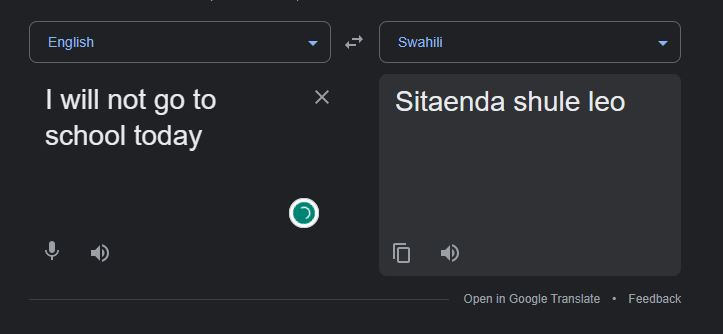

# Deployment Of the Model

There are several ways to deploy a machine learning model including flask, Streamlit and others.For now we have deployed using gradio which is a python ui for proving interfaces for machine learning projects using short lines of code

In [ ]:

!pip -q install gradio==3.47.1

In [ ]:
!pip -q install -U typing_extensions
#!pip -q install typing_extensions==4.7.1 --upgrade


In [ ]:
import gradio as gr

Create a function to generate the output text from the translation pipeline

In [ ]:
def translate_transformers(from_text):
    results = fine_tuned_model(from_text)
    return results[0]['translation_text']

Pass the function to gradio interface. You can cahnge the place holder to suite your own preferences

In [ ]:
interface = gr.Interface(
    fn=translate_transformers,
  inputs='textbox',
             outputs='textbox').launch(share=True);



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://958cb83721c407630c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Finnally launch the model. You can use here or click on the link to you use on your browser window

# The END

## You have successfully fine-tuned and deployed a model for a translation task <br> CONGRACULATIONS!